# HAT-P-70B

Maybe needs an eclipse?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [3]:
name = 'HAT-P-70B'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [5]:
visit = om.Visit.from_files(np.sort(fnames), forward=False)

In [7]:
obs = om.Observation.from_files(fnames)

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])]
HAT-P-70B Visit 1, Forward True [Proposal ID: 16307]
HAT-P-70B Visit 1, Forward False [Proposal ID: 16307]


In [9]:
obs

HAT-P-70B [2 Visits]

In [10]:
obs

HAT-P-70B [2 Visits]

In [11]:
clc = lk.search_lightcurve(name, author='SPOC', exptime=120).download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

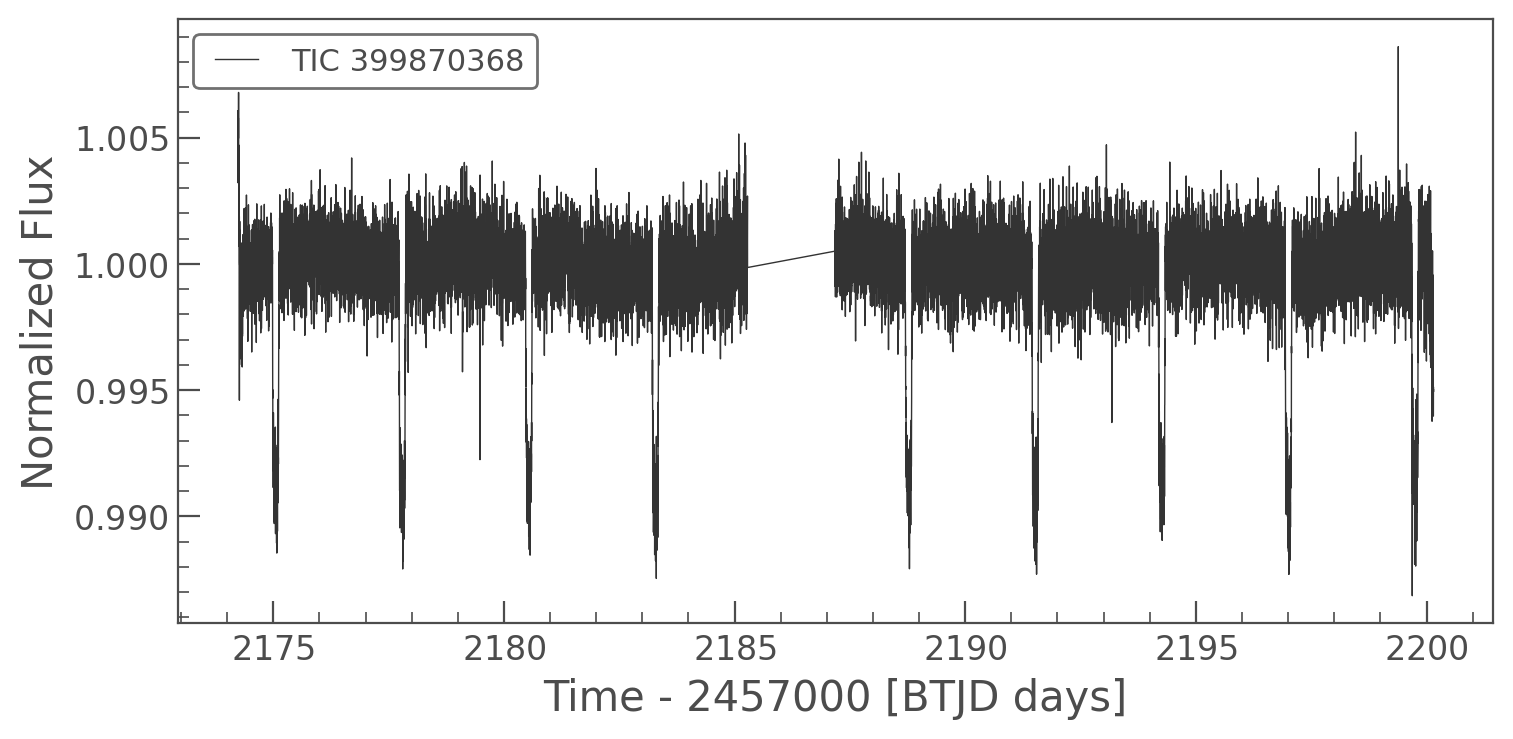

In [12]:
clc.plot()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

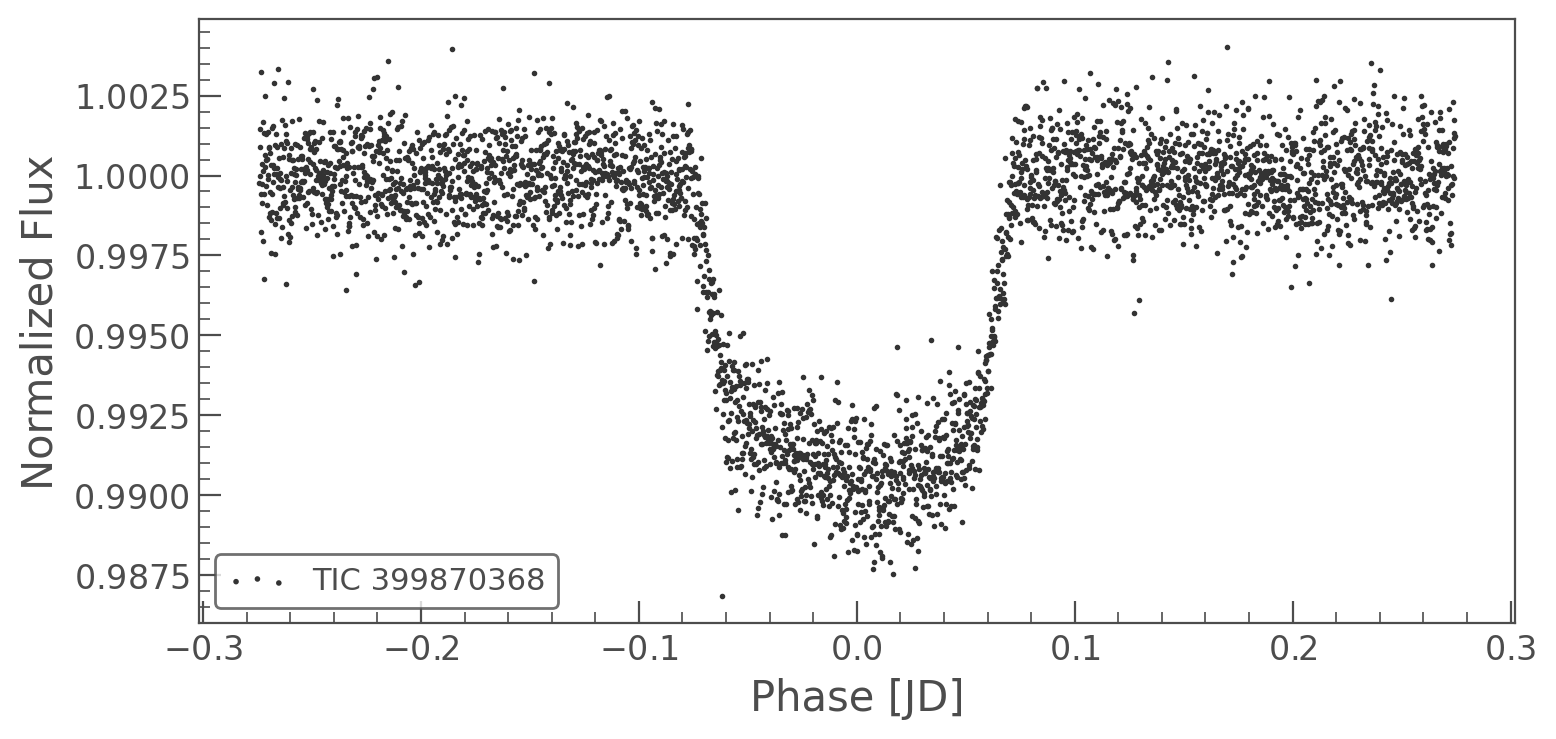

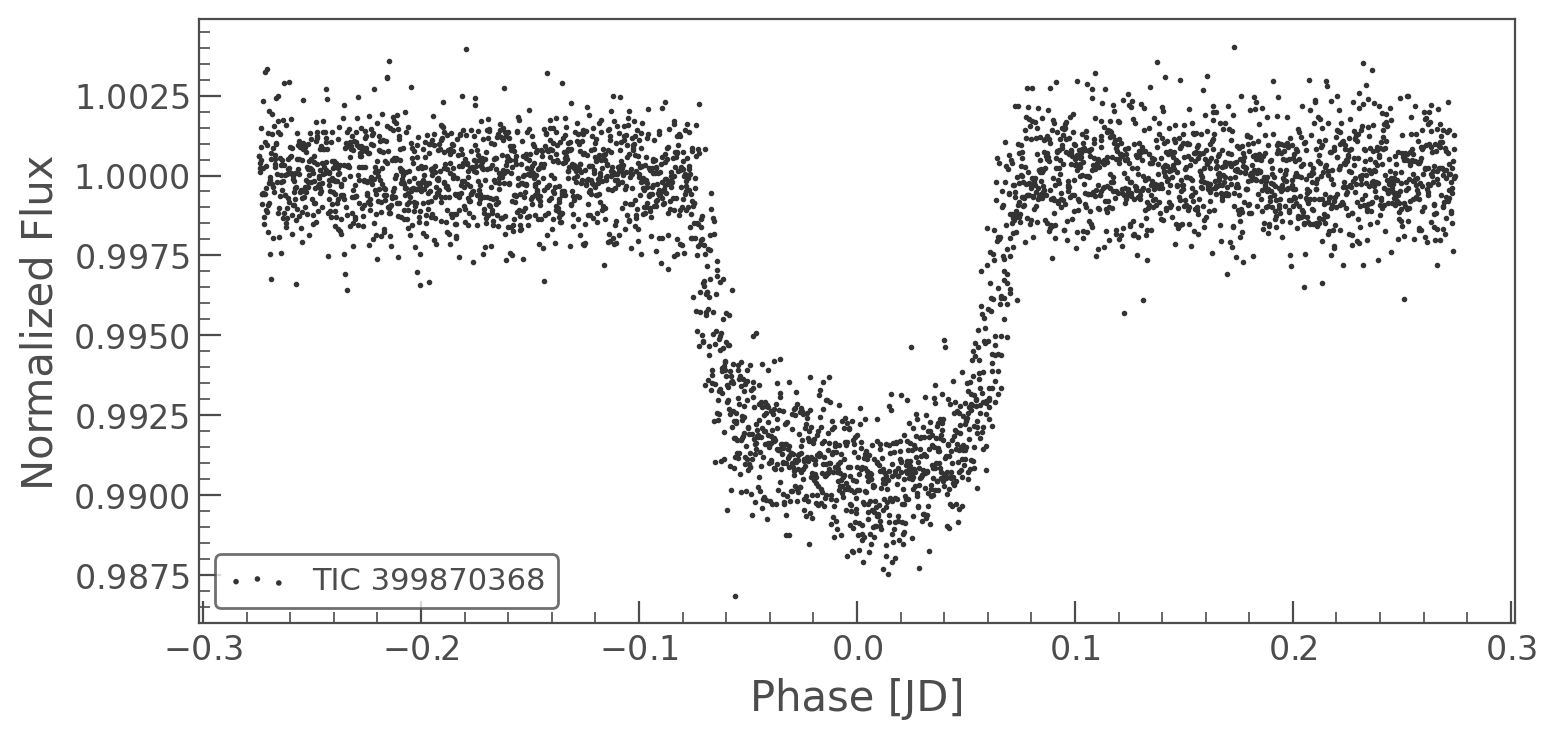

In [13]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

bls = clc.to_periodogram('bls', minimum_period=obs.period * 0.99, maximum_period=obs.period * 1.01, duration=obs.duration/24, frequency_factor=0.1)
obs.period, obs.t0 = bls.period_at_max_power.value, bls.transit_time_at_max_power.value + 2457000

k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [14]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True, calc_eclipse=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

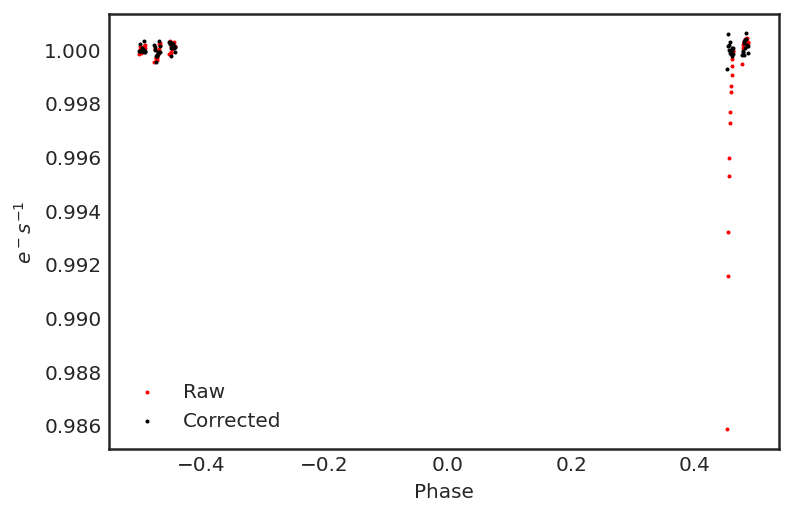

In [15]:
obs.plot()

In [16]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 2/2 [00:26<00:00, 13.24s/it]


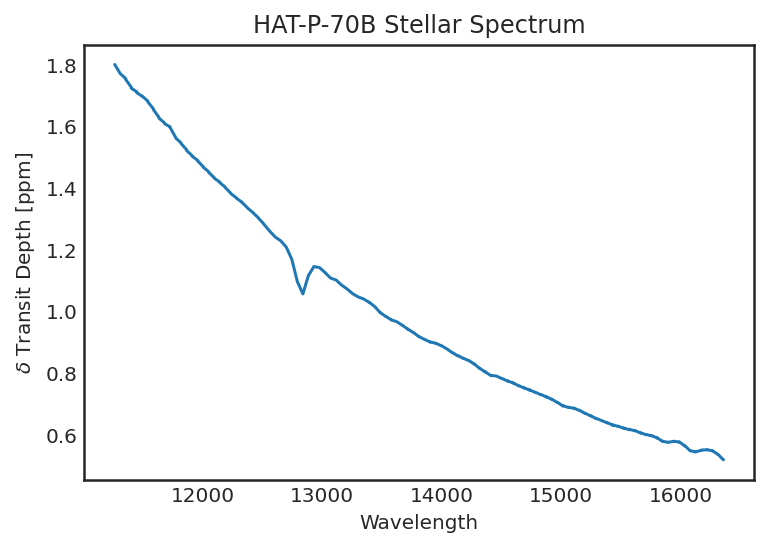

In [17]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

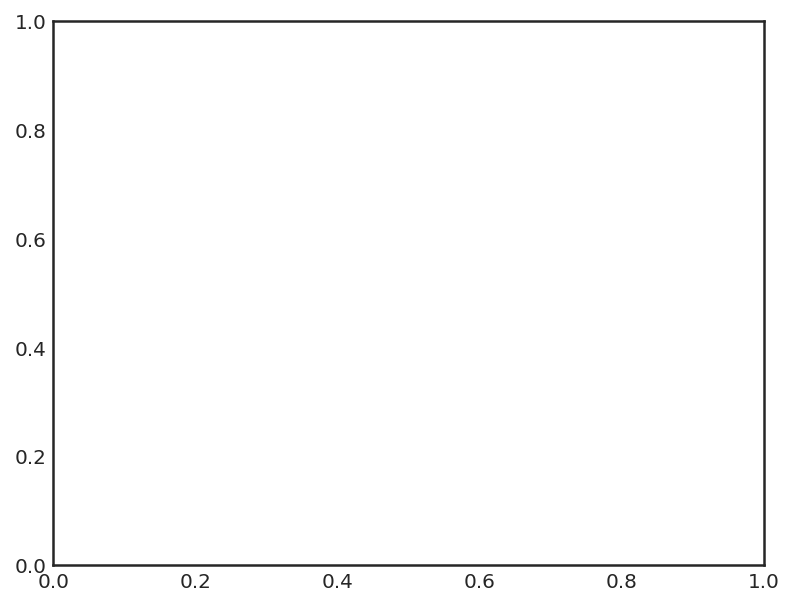

[Text(0.5, 1.0, 'WASP-107 Transmission Spectrum')]

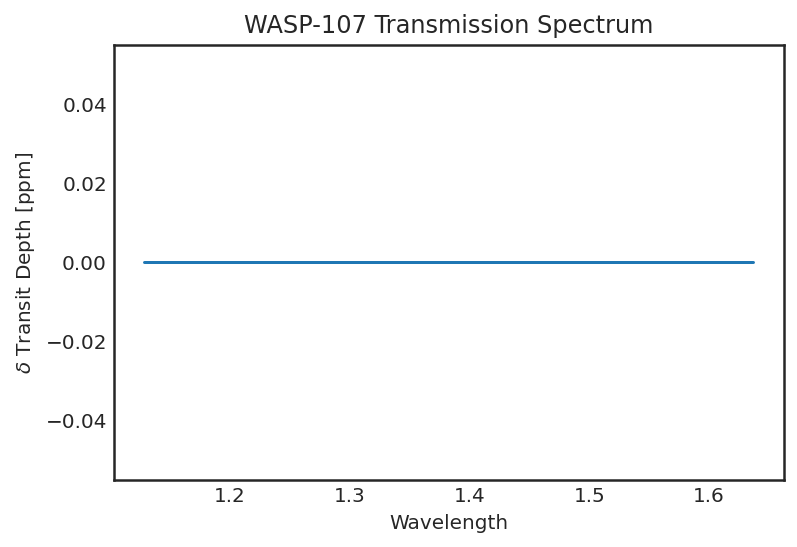

In [19]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [20]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

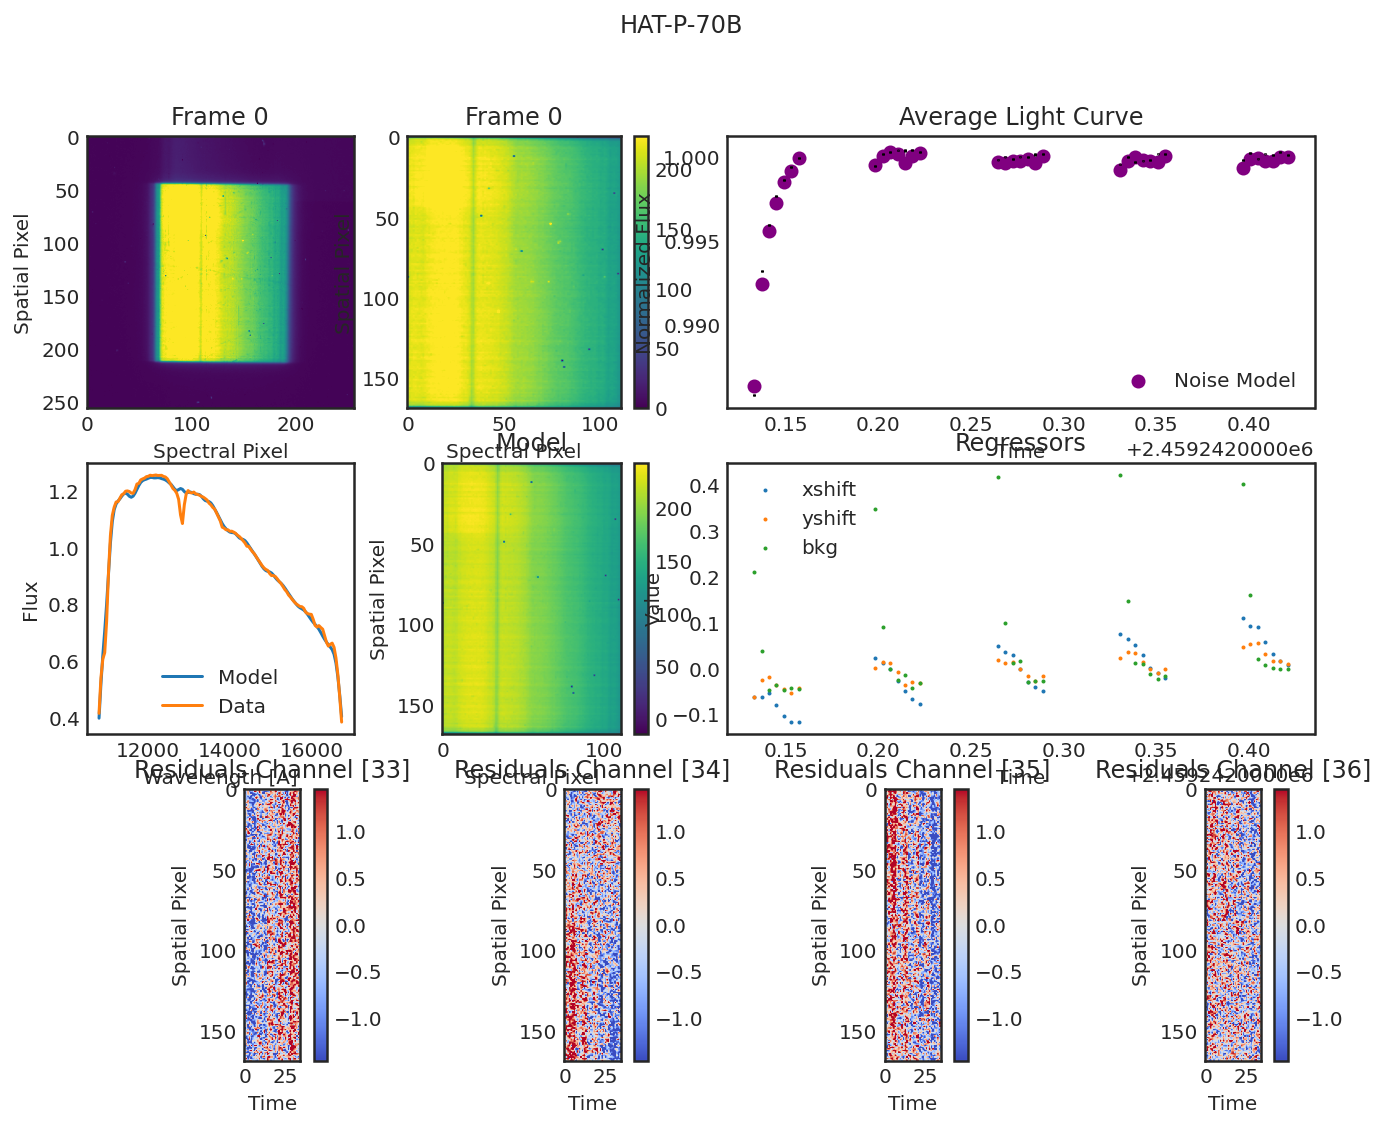

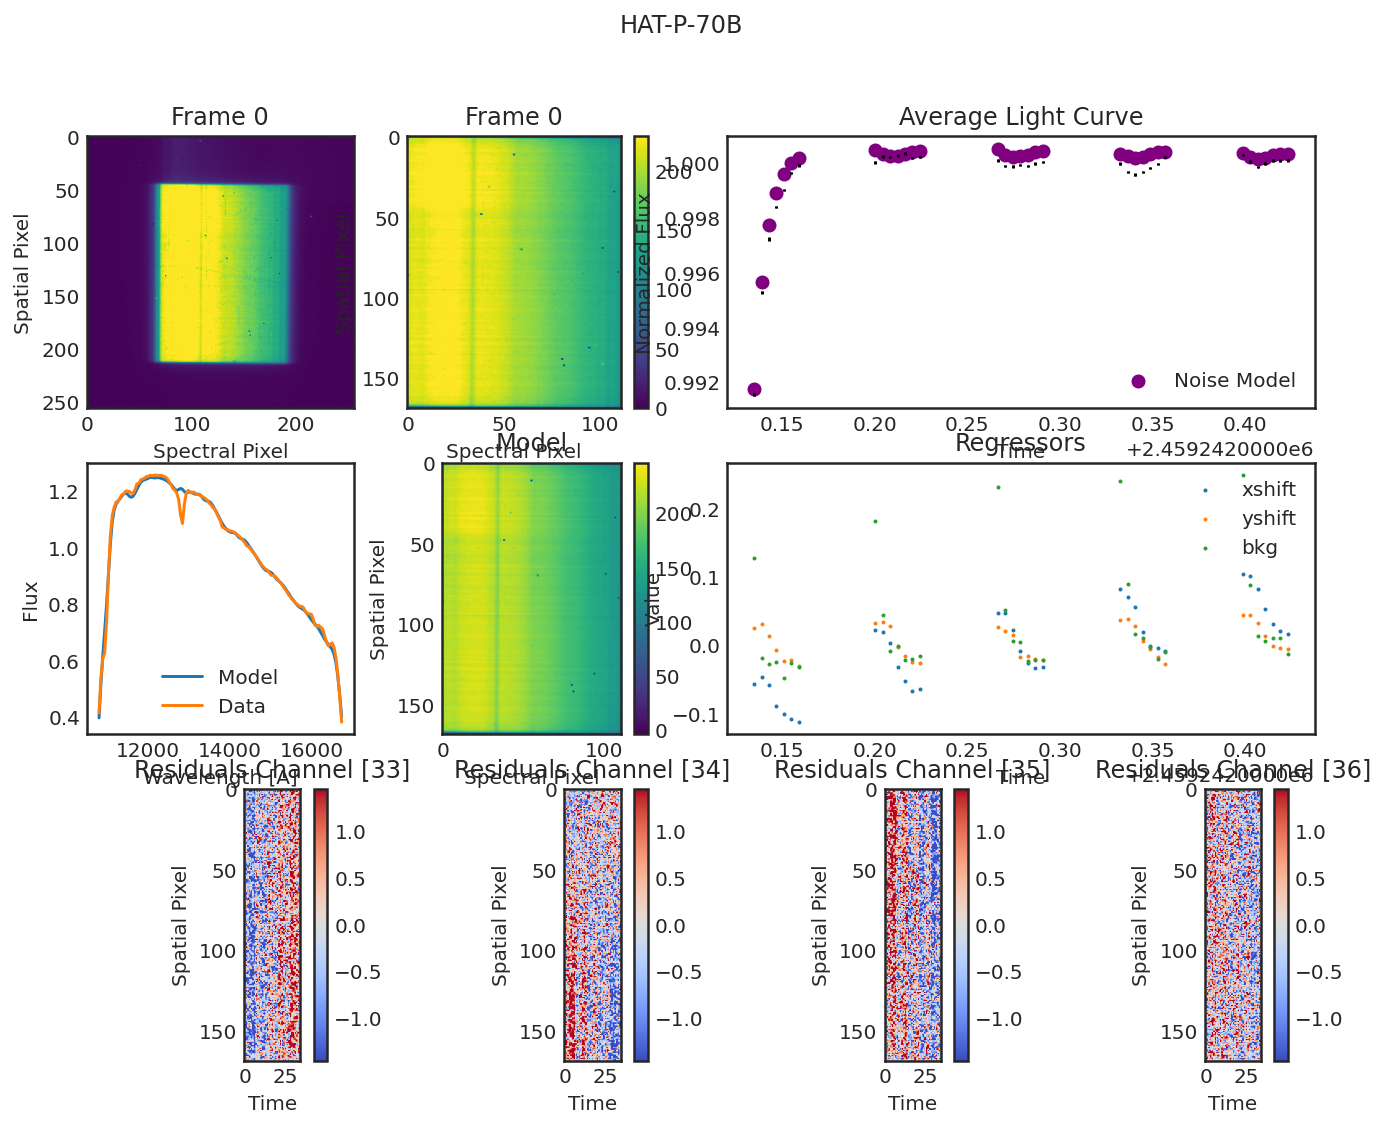

In [21]:
for visit in obs:
    visit.diagnose();
    plt.show();